# Text Clustering using Enron Emails with K-Means 

This is an example of using K-Means clustering for clustering a text dataset of email content. This uses some data pre-processing steps from the Kaggle forum and builds upon to vectorize and perform K-Means and MiniBatch K-Means clustering using python and scikit-learn. 

I used the Silhouette score to help identify the best k clusters and it came up with 4 clusters. Originally I started with 2 clusters, this should be modified in the code. While running this it's important to note the K-Means model trains very slow, while testing and making iterations it's much quicker to use the more scalable minibatch on the dataset. Aside from subsetting the data I am not aware of methods to speed performance up on the sklearn k-means model. I also ran into an issue using the Silhouette score method, by default this would always run out of memory on my pcs. To work around this I used a sample which doesn't seem to have a large affect based on size. Further analysis could include viewing the top tokens from each of the clusters and looking into what categories or types of content they are associating with. 

In [1]:
import pandas as pd
import email
import spacy
import textacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import sklearn
import mglearn

import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load('en')  # spacy english model

In [2]:
# Read in the dataset
df = pd.read_csv('../data/emails.csv')
print(df.iloc[0]['message'])  # Print what the data contains

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


## Data Parsing and Cleaning 

In [3]:
'''
Data parsing and loading functions based from Zichen -- thank you for sharing your exploration!
Using this to better keep the information if we want it later it's easier to process. 
https://www.kaggle.com/zichen/explore-enron
'''
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

df.head(2)  # print example

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p


In [4]:
def clean_preprocess(doc):
    """ Function to clean and run the text pre-processing steps.
    1. Lowercase
    2. Punctuation
    3. Stopwords
    :param doc: string
    :returns: text
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc.split(' ') if not w in spacy.en.STOP_WORDS]
    
    # Custom stopwords to remove
    rm = ['-PRON-']
    doc = [w for w in doc if not w in rm]
    
    string = ' '.join(doc).replace('\n\n',' ').replace('\n', ' ')
    return string

# Apply function to df 
df['processed_content'] = df.content.apply(clean_preprocess)

## Vectorize Text

In [6]:
tfidf_vector = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
x_data = tfidf_vector.fit_transform(df['processed_content'])

In [9]:
tfidf_vector.get_feature_names()[-588]

'zuch'

## K-Means Clustering

In [ ]:
clf = KMeans(n_clusters=4)
labels = clf.fit(x_data)

In [10]:
# Pickle model
#sklearn.externals.joblib.dump(labels, 'kmeans.pkl')

# Load model
labels = sklearn.externals.joblib.load('kmeans.pkl')

In [12]:
# Cluster memberships
print(labels.labels_[60:100])

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [13]:
len(labels.labels_)

517401

## Minibatch K-Means

In [14]:
clf_mb = MiniBatchKMeans(n_clusters=4)
%time mb_labels = clf_mb.fit(x_data)

CPU times: user 54.9 s, sys: 3.96 s, total: 58.9 s
Wall time: 60 s


## Top Terms per cluster

Using something like these top cluster terms is a good way to shed light into the individual clusters. This could help with identifying topics or logical groupings.

In [15]:
vocab_frame = pd.DataFrame({'words': tfidf_vector.get_feature_names()[:]}, 
                           index = tfidf_vector.get_feature_names()[:])

In [17]:
order_centroids = clf_mb.cluster_centers_.argsort()[:, ::-1] 

for i in range(4):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[tfidf_vector.get_feature_names()[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print('') 

Cluster 0 words: b'message', b'original', b'sent', b'email', b'2001', b'subject', b'pm', b'intended', b'recipient', b'enron', b'october', b'thanks', b'monday', b'tuesday', b'november', b'cc', b'2002', b'wednesday', b'fw', b'thursday',
Cluster 1 words: b'20', b'final', b'detected', b'variances', b'hour', b'hourahead', b'09', b'schedulingiso', b'oportlandwestdeskcalifornia', b'parsing', b'ancillary', b'awarded', b'schedules', b'log', b'messages', b'schedule', b'start', b'date', b'file', b'enron',
Cluster 2 words: b'1400', b'77002', b'7136463490', b'smith', b'eb', b'street', b'texas', b'america', b'perlingiere', b'debra', b'north', b'7138537658', b'3885', b'fax', b'houston', b'corp', b'dperlinenroncom', b'phone', b'enron', b'legal',
Cluster 3 words: b'thanks', b'enron', b'pm', b'subject', b'cc', b'know', b'attached', b'time', b'let', b'new', b'need', b'email', b'meeting', b'power', b'gas', b'forwarded', b'energy', b'deal', b'like', b'questions',


## Finding K Clusters

Using MiniBatch K-Means on the full dataset since K-means takes a long time with this data. These can be swapped out very easily if needed. When the Silhouette score is higher the clusters are the clearest. This is found around 4 clusters seen in the plot below. 

In [21]:
sil_scores = []

for n_clusters in range(2,9):
    k_mini = MiniBatchKMeans(n_clusters=n_clusters)
    k_mini.fit(x_data)
    
    labels = k_mini.labels_
    centr = k_mini.cluster_centers_
    # Need to use smaller sample size -- runs out of memory and crashes kernel
    sil_scores.append(silhouette_score(x_data, labels, metric='euclidean', sample_size=2000))  #

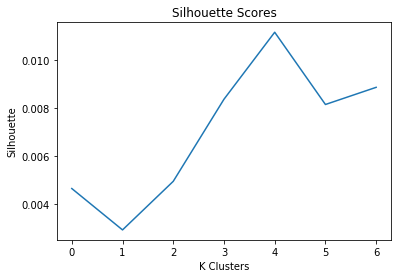

In [22]:
plt.plot(sil_scores)
plt.title('Silhouette Scores')
plt.ylabel('Silhouette')
plt.xlabel('K Clusters')
plt.show()

## Resources

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

http://brandonrose.org/clustering

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://www.kaggle.com/jaykrishna/topic-modeling-enron-email-dataset

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

https://datascience.stackexchange.com/questions/6508/k-means-incoherent-behaviour-choosing-k-with-elbow-method-bic-variance-explain

https://www.youtube.com/watch?v=vgmL808eSw4